# POP MOC(z) for 1-degree
 - Computes MOC(z) offline from POP history file velocity fields
 - Demonstrates offline/online match for MOC(z) computation (to within round-off) 

In [1]:
%load_ext autoreload
%autoreload 2
import xarray as xr 
import numpy as np  
import cftime
import matplotlib.pyplot as plt
%matplotlib inline

### Read in history file & MOC template file

In [2]:
fpop = '/glade/scratch/yeager/POP_MOC/g210.GIAF_JRA.v14.gx1v7.02.pop.h.0157-01.nc'
ds = xr.open_dataset(fpop)
fmoc = '/glade/u/home/yeager/analysis/python/POP_MOC/moc_template.nc'
ds_moctemp = xr.open_dataset(fmoc)

### Compute Volume Fluxes

In [3]:
v_e = ds['VVEL']
v_e = v_e.where(v_e<1.e30,0)
v_i = ds['VISOP'].drop(['ULONG','TLAT'])
v_i = v_i.where(v_i<1.e30,0)
v_s = ds['VSUBM'].drop(['ULONG','TLAT'])
v_s = v_s.where(v_s<1.e30,0)

w_e = ds['WVEL'].drop(['ULONG','ULAT'])
w_e = w_e.where(w_e<1.e30,0)
w_i = ds['WISOP'].drop(['ULONG','ULAT'])
w_i = w_i.where(w_i<1.e30,0)
w_s = ds['WSUBM'].drop(['ULONG','ULAT'])
w_s = w_s.where(w_s<1.e30,0)

In [4]:
# shift VVEL to 3121 position
def shiftVVEL(v):
    v_w = v.roll(nlon=1,roll_coords=False)
    v = 0.5*(v+v_w)
    return v.drop(['ULONG','TLAT'])

v_e = shiftVVEL(v_e)

In [5]:
# grid-oriented volume fluxes in m^3/s
tarea = ds['TAREA'].drop(['ULONG','ULAT'])
w_e = w_e*tarea/1.e6
w_i = w_i*tarea/1.e6
w_s = w_s*tarea/1.e6

In [6]:
# grid-oriented volume fluxes in m^3/s
dxdz = ds['HTN'].drop(['ULONG','TLAT'])*ds['dz']
v_e = v_e*dxdz/1.e6
v_i = v_i*dxdz/1.e6
v_s = v_s*dxdz/1.e6

In [7]:
# Combine fluxes into multi-component arrays
wflux = xr.concat([w_e,w_i,w_s],dim=ds_moctemp.moc_components)
vflux = xr.concat([v_e,v_i,v_s],dim=ds_moctemp.moc_components)

#### add an extra level corresponding to zero values at ocean floor.

In [8]:
wflux_bot = xr.zeros_like(wflux.isel(z_w_top=-1))
wflux_bot['z_w_top'] = ds.z_w_bot[-1].data
wflux = xr.concat([wflux,wflux_bot],dim='z_w_top').rename({'z_w_top':'moc_z'})

vflux_bot = xr.zeros_like(vflux.isel(z_t=-1))
vflux_bot['z_t'] = ds.z_w_bot[-1].data
vflux = xr.concat([vflux,vflux_bot],dim='z_t')

### MOC Region Mask

In [ ]:
## Define the MOC region mask:
rmask = ds_grid.REGION_MASK.drop(['ULONG','ULAT'])
rmaskglob = xr.where((rmask>0),1,0)
rmaskatl = xr.where((rmask>=6) & (rmask<=11),1,0)
rmaskmoc = xr.concat([rmaskglob,rmaskatl],dim=ds_moctemp.transport_regions)

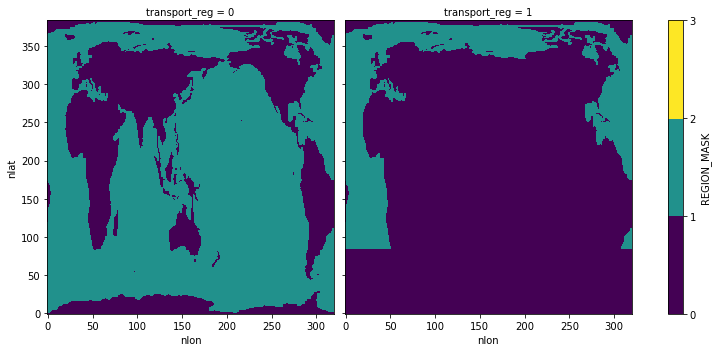

In [10]:
rmaskmoc.plot(levels=[0,1,2,3],col='transport_reg',size=5);

### Compute MOC

In [11]:
from xhistogram.xarray import histogram

def wflux_zonal_sum(wflux,regionmask,lat):
    """ 
    Compute zonally-integrated vertical volume flux for each region defined by regionmask, 
    using lat as the target latitude grid. Uses a workaround for bug in histogram keep_coords option. 
    """
    wgts = wflux*rmaskmoc
    
    # Use workaround for xhistogram bug (https://github.com/xgcm/xhistogram/pull/79). In future,
    # use keep_coords=True.
    xr_out = histogram(wflux.TLAT, bins=[lat],weights=wgts,dim=['nlat','nlon'],density=False)
    xr_out = xr_out.assign_coords(wgts.drop(['TLAT','TLONG']).coords)
    
    # Add zeros at southern edge in preparation for meridional integral:
    tmp = xr.zeros_like(xr_out.isel(TLAT_bin=0))
    tmp['TLAT_bin'] = tmp['TLAT_bin'] - 1.
    xr_out = xr.concat([tmp,xr_out],dim='TLAT_bin').rename({'TLAT_bin':lat.name})
    xr_out[lat.name] = lat
    return xr_out 

def compute_MOC(wflux,regionmask,lat):
    # first compute wflux zonal sum binned by latitude using histogram
    zonsum = wflux_zonal_sum(wflux,regionmask,lat)
    
    # compute cumulative meridional sum (south to north)
    moc = zonsum.cumsum(dim=lat.name)
    
    # convert to Sv
    moc = moc/1.e6
    moc = moc.assign_attrs({'long_name':'Meridional Overturning Circulation','units':'Sv'})
    moc.name = 'MOC'
    
    return moc

In [12]:
%%time
MOCnew = compute_MOC(wflux,rmaskmoc,ds_moctemp.lat_aux_grid)

CPU times: user 1.2 s, sys: 406 ms, total: 1.6 s
Wall time: 1.63 s


### Add Atlantic southern boundary overturning (this includes throughflow)

In [13]:
# determine j=index of Atlantic region southern boundary
tmp = rmaskmoc.isel(transport_reg=1).sum('nlon')
atl_j = 0
j = 0
while (atl_j==0):
    if (tmp.isel(nlat=j).data>0):
        atl_j = j
    j += 1
atl_j = atl_j - 1
atl_j

84

In [14]:
# add vflux at southern boundary of Atlantic domain
tmp = vflux*(rmaskmoc.shift(nlat=-1))
tmp = tmp.isel(nlat=atl_j,transport_reg=1).sum('nlon').rename({'z_t':'moc_z'})
mocatl_s = -tmp.sortby('moc_z',ascending=False).cumsum('moc_z').sortby('moc_z',ascending=True)/1.e6
mocatl_s['moc_z'] = MOCnew['moc_z']

In [15]:
MOCnew[{'transport_reg':1}] = MOCnew[{'transport_reg':1}] + mocatl_s

### Evaluate difference from online-computed MOC

In [16]:
MOCorig = ds['MOC']
MOCdiff = MOCnew - MOCorig

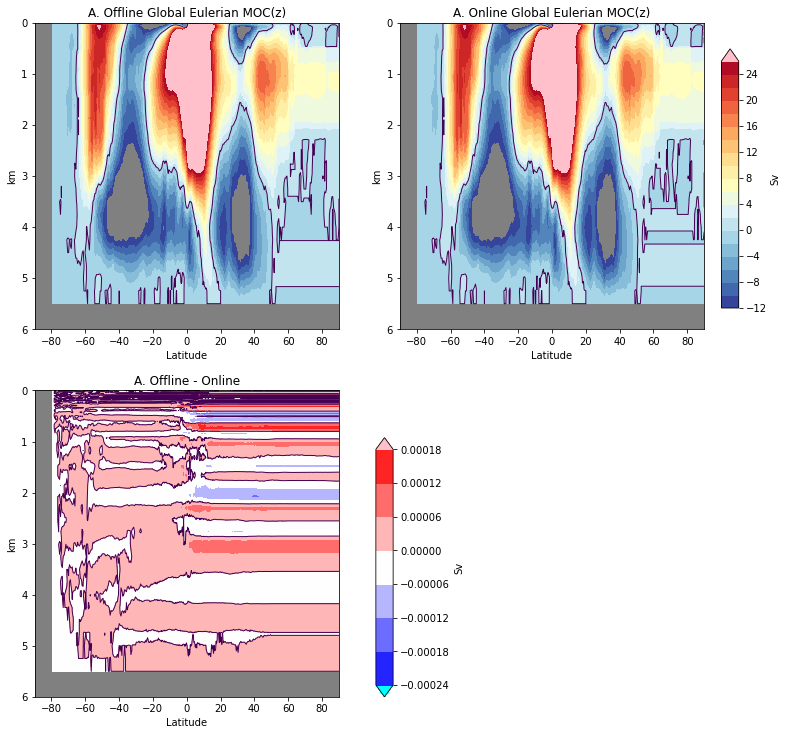

In [19]:
# Plot MOC
import copy

fig = plt.figure(figsize=(12,12))
mnlevs = np.arange(0,20,1)*2. - 12.
mycmap = copy.copy(plt.cm.RdYlBu_r)
xlim=[-30,70]
ylim=[6,0]

mc = 0   # moc_comp
compstr = 'Eulerian'
#mc = 1   # moc_comp
#compstr = 'Bolus'
#mc = 2   # moc_comp
#compstr = 'Submeso'

tr = 0   # transport_reg
trstr = 'Global'

ax = fig.add_subplot(2,2,1)
ax.set_title('A. Offline {} {} MOC(z)'.format(trstr,compstr))
cntr1 = ax.contourf(MOCnew.lat_aux_grid, MOCnew.moc_z/1.e5, MOCnew.isel(time=0,moc_comp=mc,transport_reg=tr),levels=mnlevs, cmap=mycmap,extend='max')
ax.contour(MOCnew.lat_aux_grid, MOCnew.moc_z/1.e5, MOCnew.isel(time=0,moc_comp=mc,transport_reg=tr),levels=[0.], linewidths=1)
cntr1.cmap.set_over('pink')
ax.set_ylim([6,0])
ax.set_xlim([-90,90])
ax.set_xlabel('Latitude')
ax.set_ylabel('km')
ax.set_facecolor('grey')

ax = fig.add_subplot(2,2,2)
ax.set_title('A. Online {} {} MOC(z)'.format(trstr,compstr))
cntr2 = ax.contourf(MOCorig.lat_aux_grid, MOCorig.moc_z/1.e5, MOCorig.isel(time=0,moc_comp=mc,transport_reg=tr),levels=mnlevs, cmap=mycmap,extend='max')
ax.contour(MOCorig.lat_aux_grid, MOCorig.moc_z/1.e5, MOCorig.isel(time=0,moc_comp=mc,transport_reg=tr),levels=[0.], linewidths=1)
cntr2.cmap.set_over('pink')
ax.set_ylim([6,0])
ax.set_xlim([-90,90])
ax.set_xlabel('Latitude')
ax.set_ylabel('km')
ax.set_facecolor('grey')

diffcmap = copy.copy(plt.cm.bwr)
difflevs = np.arange(0,20,1)*2. - 12.
ax = fig.add_subplot(2,2,3)
ax.set_title('A. Offline - Online')
cntr3 = ax.contourf(MOCdiff.lat_aux_grid, MOCdiff.moc_z/1.e5, MOCdiff.isel(time=0,moc_comp=mc,transport_reg=tr),cmap=diffcmap,extend='both')
ax.contour(MOCdiff.lat_aux_grid, MOCdiff.moc_z/1.e5, MOCdiff.isel(time=0,moc_comp=mc,transport_reg=tr),levels=[0.], linewidths=1)
cntr3.cmap.set_over('pink')
cntr3.cmap.set_under('cyan')
ax.set_ylim([6,0])
ax.set_xlim([-90,90])
ax.set_xlabel('Latitude')
ax.set_ylabel('km')
ax.set_facecolor('grey')


fig.subplots_adjust(bottom=0.1,right=0.9)
cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.3])
fig.colorbar(cntr1, cax=cbar_ax, label='Sv', orientation='vertical')
cbar_ax2 = fig.add_axes([0.52, 0.1, 0.02, 0.3])
fig.colorbar(cntr3, cax=cbar_ax2, label='Sv', orientation='vertical')

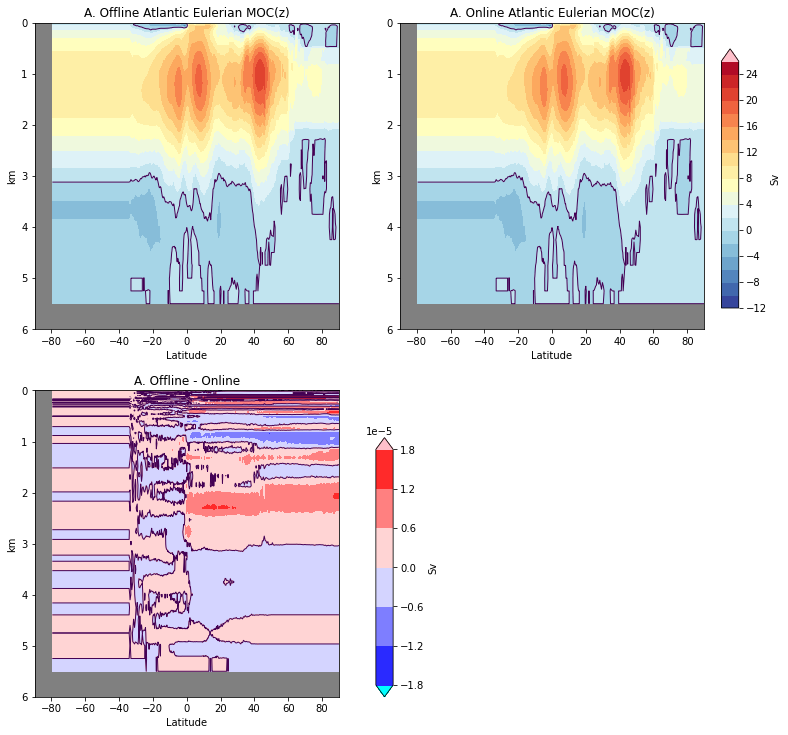

In [20]:
# Plot MOC

fig = plt.figure(figsize=(12,12))
mnlevs = np.arange(0,20,1)*2. - 12.
mycmap = copy.copy(plt.cm.RdYlBu_r)
xlim=[-30,70]
ylim=[6,0]

mc = 0   # moc_comp
compstr = 'Eulerian'
#mc = 1   # moc_comp
#compstr = 'Bolus'
#mc = 2   # moc_comp
#compstr = 'Submeso'

tr = 1   # transport_reg
trstr = 'Atlantic'

ax = fig.add_subplot(2,2,1)
ax.set_title('A. Offline {} {} MOC(z)'.format(trstr,compstr))
cntr1 = ax.contourf(MOCnew.lat_aux_grid, MOCnew.moc_z/1.e5, MOCnew.isel(time=0,moc_comp=mc,transport_reg=tr),levels=mnlevs, cmap=mycmap,extend='max')
ax.contour(MOCnew.lat_aux_grid, MOCnew.moc_z/1.e5, MOCnew.isel(time=0,moc_comp=mc,transport_reg=tr),levels=[0.], linewidths=1)
cntr1.cmap.set_over('pink')
ax.set_ylim([6,0])
ax.set_xlim([-90,90])
ax.set_xlabel('Latitude')
ax.set_ylabel('km')
ax.set_facecolor('grey')

ax = fig.add_subplot(2,2,2)
ax.set_title('A. Online {} {} MOC(z)'.format(trstr,compstr))
cntr2 = ax.contourf(MOCorig.lat_aux_grid, MOCorig.moc_z/1.e5, MOCorig.isel(time=0,moc_comp=mc,transport_reg=tr),levels=mnlevs, cmap=mycmap,extend='max')
ax.contour(MOCorig.lat_aux_grid, MOCorig.moc_z/1.e5, MOCorig.isel(time=0,moc_comp=mc,transport_reg=tr),levels=[0.], linewidths=1)
cntr2.cmap.set_over('pink')
ax.set_ylim([6,0])
ax.set_xlim([-90,90])
ax.set_xlabel('Latitude')
ax.set_ylabel('km')
ax.set_facecolor('grey')

diffcmap = copy.copy(plt.cm.bwr)
difflevs = np.arange(0,20,1)*2. - 12.
ax = fig.add_subplot(2,2,3)
ax.set_title('A. Offline - Online')
cntr3 = ax.contourf(MOCdiff.lat_aux_grid, MOCdiff.moc_z/1.e5, MOCdiff.isel(time=0,moc_comp=mc,transport_reg=tr),cmap=diffcmap,extend='both')
ax.contour(MOCdiff.lat_aux_grid, MOCdiff.moc_z/1.e5, MOCdiff.isel(time=0,moc_comp=mc,transport_reg=tr),levels=[0.], linewidths=1)
cntr3.cmap.set_over('pink')
cntr3.cmap.set_under('cyan')
ax.set_ylim([6,0])
ax.set_xlim([-90,90])
ax.set_xlabel('Latitude')
ax.set_ylabel('km')
ax.set_facecolor('grey')


fig.subplots_adjust(bottom=0.1,right=0.9)
cbar_ax = fig.add_axes([0.92, 0.55, 0.02, 0.3])
fig.colorbar(cntr1, cax=cbar_ax, label='Sv', orientation='vertical')
cbar_ax2 = fig.add_axes([0.52, 0.1, 0.02, 0.3])
fig.colorbar(cntr3, cax=cbar_ax2, label='Sv', orientation='vertical')